# SOMOSPIE
## SOil MOisture SPatial Inference Engine

### Introduction

Soil moisture is a critical variable that links climate dynamics with water and food security. It regulates land-atmosphere interactions (e.g., via evapotranspiration--the loss of water from evaporation and plant transpiration to the atmosphere), and it is directly linked with plant productivity and survival. Information on soil moisture is important to design appropriate irrigation strategies to increase crop yield, and long-term soil moisture coupled with climate information provides insights into trends and potential agricultural thresholds and risks. Thus, information on soil moisture is a key factor to inform and enable precision agriculture.

The current availability in soil moisture data over large areas comes from remote sensing (i.e., satellites with radar sensors) which provide daily, nearly global coverage of soil moisture. However, satellite soil moisture datasets have a major shortcoming in that they are limited to coarse spatial resolution (generally no finer than tens of kilometers).

There do exist at higher resolution other geographic datasets (e.g., climatic, geological, and topographic) that are intimately related to soil moisture values. SOMOSPIE is meant to be a general-purpose tool for using such datasets to downscale (i.e., increase resolution) satelite-based soil moisture products. This Jupyter Notebook is a result of a collaboration between computer scientists of the Global Computing Laboratory at the Universtiy of Tennessee, Knoxville and soil scientists at the University of Delware (funded by NSF awards #1724843 and #1854312).

# Environment Setup

Run the following code box to load the Python and R libraries and basic functions necessary for this workflow

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [ ]:
# This conditional is in case you are rerunning this cell 
#  after running a different cell that changed the working directory. 
if 'note_START' in globals():
    %cd $note_START
else:
    note_START = %pwd

# If this codebox has an error that says ipywe doesn't exist,
#  then uncomment the following and rerun the cell
#!make submodules

%run -it code/workflow_jupyter-notebook/utils.py

from os.path import abspath
note_DATA = abspath(SUB_DATA)
note_CODE = abspath(SUB_CODE)
note_OUT = abspath(SUB_OUTP)



Now your environment is setup to run the SOMOSPIE Notebook. 
In particular, the following are key folders:
* `note_START`: The working directory, the folder that contains this .ipynb.
* `note_DATA`: The subfolder for data to be loaded and pre-processed.
* `note_CODE`: The subfolder where the scripts for SOMOSPIE are held.
* `note_OUT`: The subfolder where output from SOMOSPIE is stored.

The following code cell initializes SOMOSPIE's configuration handling. Default configurations are loaded from the filename assigned to `ini_inport`. Any changes to the configuration made with this Notebook are saved to the filename assigned to `ini_export`.

In [3]:
ini_import = f"{SUB_CODE}/workflow_jupyter-notebook/SOMOSPIE_input.ini"
ini_export = f"{SUB_CODE}/workflow_jupyter-notebook/SOMOSPIE_updated_input.ini"
defaultconf = ConfigParser()
defaultconf.read(ini_import)
methods = ["1NN", "KKNN", "RF", "HYPPO", "SBM"]
conf_storage = Arg_Handler(ini_export, methods, defaultconf)

# External Data Loading

Now necessary libraries are loaded and the environment is set. Let's load in all the data you need to downscale soil moisture. Later, a subset of the data is selected for loading and making other preprocessing decisions.
The three data types we need to load are the following:
* Soil Moisture--coarse or gap-filled spatial dataset for which we need a complete dataset, possibly at higher resolution;
* Topographic (Terrain) data related to soil moisture, e.g. elevation and hill slope, covering all the points where prediction is desired;
* Region boundaries--shapefiles bounding the regions for training and prediction.

### Soil Moisture Data

In the code cell below, specify your source for soil moisture data. The available default data is automatically fetched from ESA-CCI for the range of years you specify to have available for you experiments. Currently, ESA-CCI data can be fetched for the following years: 1979--2017. The data comes from the project, hosted at: https://www.esa-soilmoisture-cci.org _Caution! Every year you include takes roughly 25 minutes to download from the ESA website._

#### Advanced: 

If you choose to Select Local File with a file you uploaded or Download Remote File from a specified url, then the file _must_ match the following specifications:
 * Acceptable file formats: .rds, .tif, .csv, .txt, .sdat.
   * If rds/tif/sdat, must be stackable in R with stack().
   * If csv/txt, but be comma-seperated.
 * Acceptable data: 14 columns, 2 for coordinates, 12 for soil moisture.
   * The first and second columns are longitude and latitude, respectively.
   * The final twelve columns are for the twelve months.

In [ ]:
%cd $note_START
sm_widgets = sm_source_widget()

In [ ]:
%cd $note_START
sm_widg = SoilMoistureData(sm_widgets)

### Topographic Data

Satellite-based soil moisture data is coarse and full of spatial gaps, so we use related topographic data to make predictions at finer resolution. By default SOMOSPIE makes predictions at the native resolution of the topographic data.

If you need sample topographic data, this notebook can fetch it for you. _Caution! Every layer you select takes a few minutes to download._

#### Advanced
If you choose to Select Local File with a file you uploaded or Download Remote File from a specified url, then the file _must_ match the following specification:
 * Spatial file with longitude/latitude coordinates.

In [ ]:
%cd $note_START
cd_widgets = cd_source_widget()

In [ ]:
%cd $note_START
cov_widg = CovariateData(cd_widgets)

### Region Data

One of the features of SOMOSPIE is region selection. Please select which region types you wish to have available.

In [ ]:
%cd $note_START
reg_type_acc = reg_type_widget()

# Input Data Selection

Now select what subset of the loaded data to use:
* Which year of ESA-CCI data do you want to use, or what is the year of the data you provided?
* Which topographic variables do you want to use, or what are the variables of the data you provided?
* Which regions do you want to use from the region-types specified above?

Execute the following code-box to activate the widgets for data selection.

In [ ]:
%cd $note_START
display(sm_widg)
print('Insert the name of the Covariates')
display(cov_widg)
reg_acc = region_widget(reg_type_acc)

# Data Processing Decisions

Now we can select what data processing to perform before applying machine-learning methods.

Execute the following code-box to activate the data processing decisions.

In [ ]:
%cd $note_CODE
procs = init_proc_widgets(conf_storage)

# Machine Learning

SOMOSPIE has 5 default Machine Learning methods built in:
* 1NN, 1-Nearest Neighbors (Python)
  * Models at each evaluation point using the value of the nearest training point.
* KKNN, Kernel-wighted K-Nearest Neighbors (Python)
  * Models locally with a weighted mean of the k nearest training points.
* RF, Random Forests (Python)
  * Models with a weighted sum of global inference trees.
* HYPPO, HYbrid Piecewise POlynomial method (Python)
  * Models with local best-fit polynomials generated by the k nearest training points. 
* SBM, Surrogate-Based Modeling (Python)
  * Models with a global best-fit polynomial generated by random samples of training points.

Execute the following code-box to activate the widget for selecting machine-learning methods and specifying their parameters. 

_NOTE: The RHS of this widget is intended to be written with Python dictionary syntax at time of writing--errors arise if values such as strings without quotes are passed._

In [ ]:
%cd $note_CODE
modictac = init_modict_widgets(conf_storage)
display(modictac)

# Let's go!

Now that you've selected all your settings, execute the following code box to run SOMOSPIE

In [ ]:
# Update configurations.
%cd $note_DATA
update_regs(reg_acc, conf_storage.args["REGIONS"])
%cd $note_START
conf_storage.args["YEAR"] = f"[{sm_widg.value}]"
if sm_widgets.children[0].value == location_data_option[1]:
    conf_storage.args["SM_FILE"] = conf_storage.args["DATA"] + f"/ESA_CCI/{sm_widg.value}_ESA_monthly.rds"
if cd_widgets.children[0].value == location_data_option[1]:
    layers = cov_widg.children[0].children
    topos = [entry.children[1].value for entry in layers if entry.children[0].value]
    topo_file, topo_labels = topo_stack(topos, agg_fact=0.5)
    conf_storage.args["COV_FILE"] = conf_storage.args["DATA"] + os.path.relpath(topo_file, start=note_DATA)
    conf_storage.args["COV_LAYERS"] = "['" + "','".join(topo_labels) + "']"
else:
    conf_storage.args["COV_LAYERS"] = cov_widg.value
conf_storage.clear_empty_files()
conf_storage.updateVars(procs, modictac)

# Make important paths absolute.
ini = os.path.abspath(ini_export)
%cd $note_CODE
wrapper = os.path.abspath("workflow_jupyter-notebook/SOMOSPIE_wrapper.py")



In [13]:
# Run SOMOSPIE, run!
bash([wrapper, ini])

# Output Visualization and Analysis

The following cells can be used to visualize any existing SOMOSPIE output -- where output is a given subfolder in the output directory. The default output is the most recently run job, but can be selected with the following cells.

None

month: 1


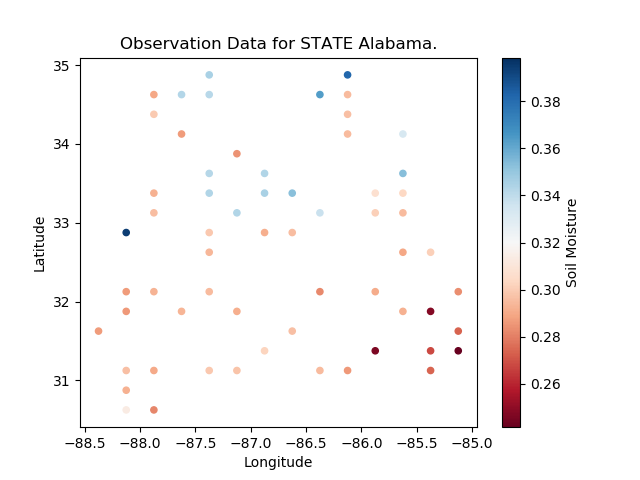

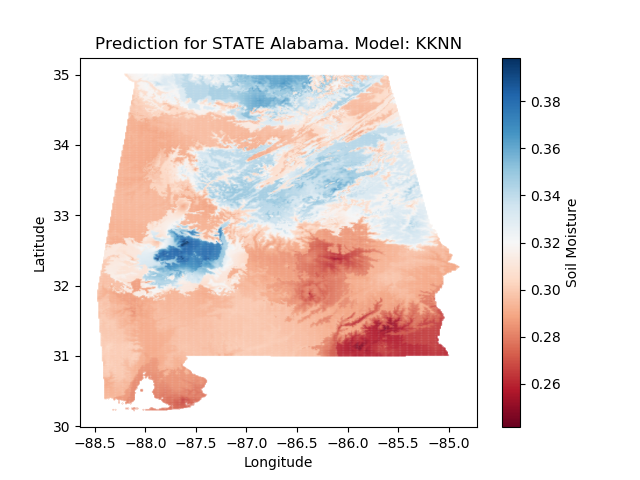

Method completion time: t=2.2860355377197266



In [14]:
#This creates and displays a folder selection widget which allows navigation of the specified output directory.
visualizer = outVis(note_OUT)

### Accuracy Analysis

The following code block reads the accuracies from the specified output into a Pandas DataFrame, then prints it for human consumption. 

In [15]:
accuracy = gather_analysis(visualizer.vis_target)
accuracy

,Year,Month,RegType,Region,Method,rmse,r2
0,2017,1,STATE,Alabama,KKNN,0.025747,0.318877
